## Getting started
创建一个手写数字的GAN  网址
https://github.com/tsuirak/deeplearning.ai

In [17]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Generator

In [18]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network   given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation  followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential( nn.Linear(input_dim, output_dim), nn.BatchNorm1d(output_dim), nn.ReLU(inplace=True) )


class Generator(nn.Module):
    '''
    Generator Class
    Values:
        in_dim: the dimension of the noise vector, a scalar
        out_dim: the dimension of the images, fitted for the dataset used, a scalar  (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, in_dim=10, out_dim=784, hidden_dim=128):
        super().__init__()
        # Build the neural network
        self.gen = nn.Sequential(
            get_generator_block(in_dim, hidden_dim),  get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4), get_generator_block(hidden_dim * 4, hidden_dim * 8),
            # There is a dropdown with hints if you need them! 
            #### START CODE HERE ####
            nn.Linear(hidden_dim * 8, out_dim),   nn.Sigmoid()
            #### END CODE HERE ####
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor,   returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)

## Discriminator

In [19]:
# GRADED FUNCTION: get_discriminator_block
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation  followed by an nn.LeakyReLU activation with negative slope of 0.2 
          (https://pytorch.org/docs/master/generated/torch.nn.LeakyReLU.html)
    '''
    return nn.Sequential(
        #### START CODE HERE ####
         nn.Linear(input_dim, output_dim), #Layer 1
         nn.LeakyReLU(0.2, inplace=True)
        #### END CODE HERE ####
    )

# UNQ_C5 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: Discriminator
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super().__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            # Hint: You want to transform the final output into a single value,
            #       so add one more linear map.
            #### START CODE HERE ####
            nn.Linear(hidden_dim, 1)
            #### END CODE HERE ####
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)
    

## Training

In [20]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001
# Load MNIST dataset as tensors
dataloader = DataLoader( MNIST('.', download=False, transform=transforms.ToTensor()),drop_last=True, batch_size=batch_size,  shuffle=True)

In [21]:
G = Generator(z_dim).to(device)
G_opt = torch.optim.Adam(G.parameters(), lr=lr)
D = Discriminator().to(device) 
D_opt = torch.optim.Adam(D.parameters(), lr=lr)

In [22]:
# UNQ_C6 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_disc_loss
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch (num_images) of fake images. 
    #            Make sure to pass the device argument to the noise.
    #       2) Get the discriminator's prediction of the fake image 
    #            and calculate the loss. Don't forget to detach the generator!
    #            (Remember the loss function you set earlier -- criterion. You need a 
    #            'ground truth' tensor in order to calculate the loss. 
    #            For example, a ground truth tensor for a fake image is all zeros.)
    #       3) Get the discriminator's prediction of the real image and calculate the loss.
    #       4) Calculate the discriminator's loss by averaging the real and fake loss
    #            and set it to disc_loss.
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!
    #### START CODE HERE ####
    fake_noise = torch.randn(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred,device=device))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2
    #### END CODE HERE ####
    return disc_loss

In [23]:
# UNQ_C7 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_gen_loss
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    #     These are the steps you will need to complete:
    #       1) Create noise vectors and generate a batch of fake images. 
    #           Remember to pass the device argument to the get_noise function.
    #       2) Get the discriminator's prediction of the fake image.
    #       3) Calculate the generator's loss. Remember the generator wants
    #          the discriminator to think that its fake images are real
    #     *Important*: You should NOT write your own loss function here - use criterion(pred, true)!

    #### START CODE HERE ####
    fake_noise = torch.randn(num_images, z_dim, device=device)
    fake = gen(fake_noise)
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    #### END CODE HERE ####
    return gen_loss

100%|██████████| 468/468 [00:09<00:00, 49.81it/s]


Step 10: Generator loss: 23.31567500925061, discriminator loss: 1.8855837831795181


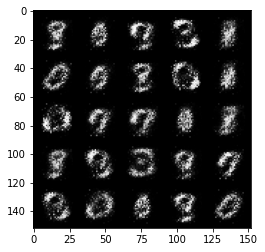

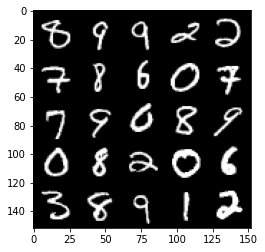

100%|██████████| 468/468 [00:09<00:00, 50.26it/s]


Step 20: Generator loss: 37.71043540239345, discriminator loss: 0.5518441790081551


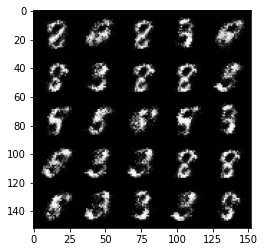

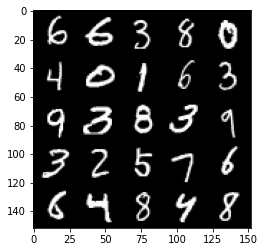

100%|██████████| 468/468 [00:08<00:00, 52.03it/s]


Step 30: Generator loss: 36.82027471733095, discriminator loss: 0.7150401579737661


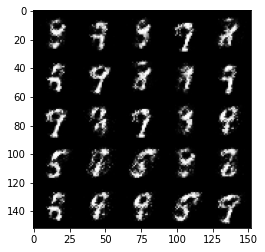

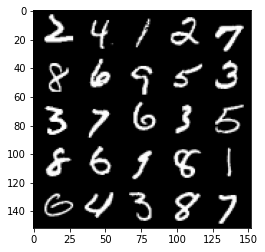

100%|██████████| 468/468 [00:09<00:00, 51.20it/s]


Step 40: Generator loss: 34.17763800287235, discriminator loss: 1.0636037547364827


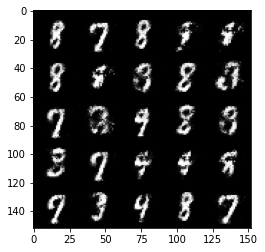

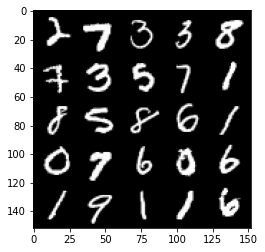

100%|██████████| 468/468 [00:09<00:00, 51.49it/s]


Step 50: Generator loss: 29.007009423732892, discriminator loss: 1.676178432926535


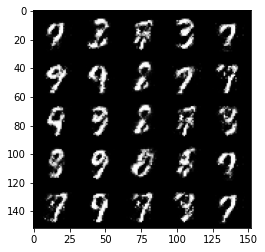

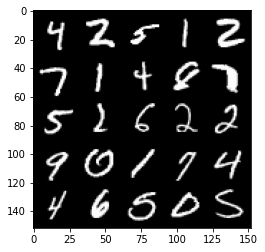

100%|██████████| 468/468 [00:09<00:00, 51.48it/s]


Step 60: Generator loss: 25.60029433965678, discriminator loss: 2.0217773288637466


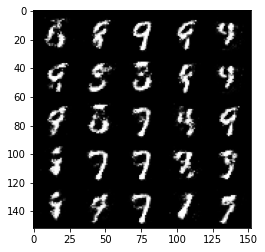

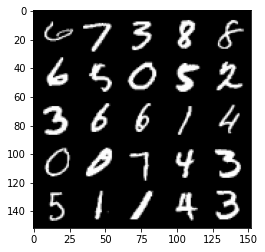

100%|██████████| 468/468 [00:09<00:00, 49.89it/s]


Step 70: Generator loss: 24.48597648143767, discriminator loss: 2.1828092685639873


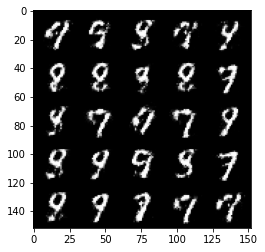

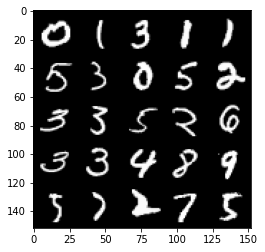

100%|██████████| 468/468 [00:08<00:00, 53.90it/s]


Step 80: Generator loss: 23.03080100488661, discriminator loss: 2.309546093001955


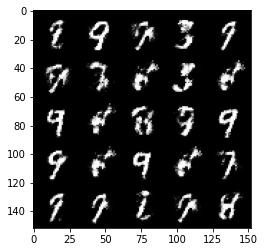

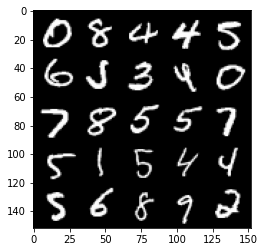

100%|██████████| 468/468 [00:09<00:00, 51.56it/s]


Step 90: Generator loss: 21.115659198284202, discriminator loss: 2.6183765232861007


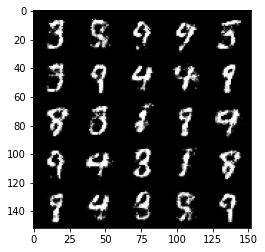

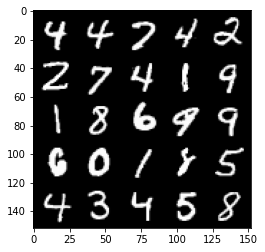

100%|██████████| 468/468 [00:09<00:00, 51.37it/s]


Step 100: Generator loss: 19.906134346961952, discriminator loss: 2.797760278463361


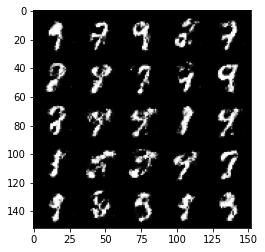

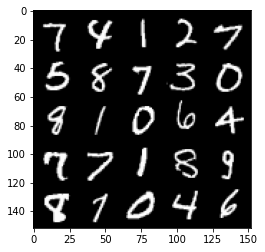

100%|██████████| 468/468 [00:09<00:00, 47.08it/s]


Step 110: Generator loss: 18.91079097199435, discriminator loss: 2.967063304662702


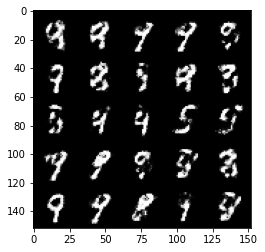

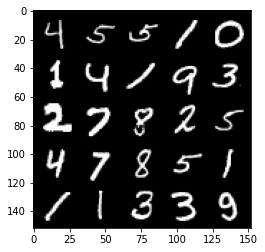

100%|██████████| 468/468 [00:09<00:00, 51.83it/s]

Step 120: Generator loss: 17.972873191356662, discriminator loss: 3.1369794228673027


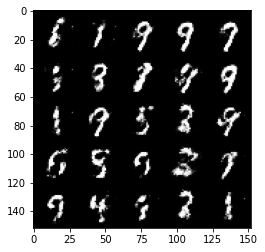

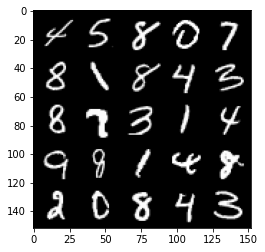

100%|██████████| 468/468 [00:09<00:00, 51.20it/s]


Step 130: Generator loss: 16.628455304622644, discriminator loss: 3.4636745160222038


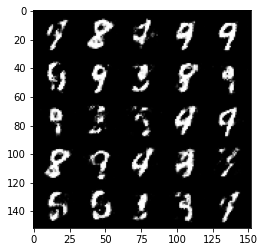

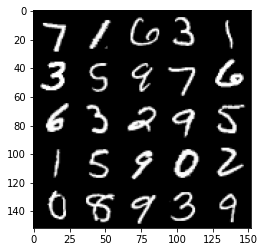

100%|██████████| 468/468 [00:08<00:00, 52.20it/s]


Step 140: Generator loss: 16.748475682973865, discriminator loss: 3.301212435513744


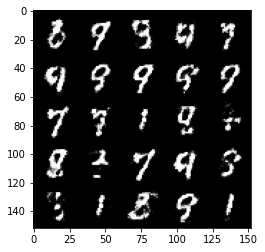

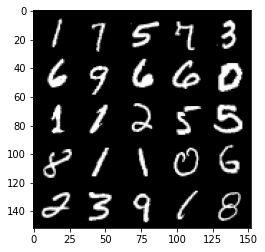

100%|██████████| 468/468 [00:09<00:00, 49.96it/s]

Step 150: Generator loss: 15.37073535966878, discriminator loss: 3.6402447763085393


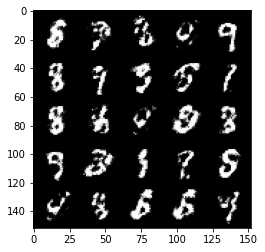

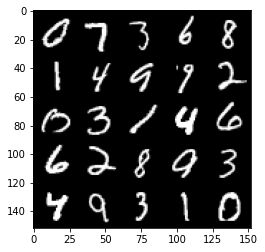

100%|██████████| 468/468 [00:09<00:00, 49.29it/s]


Step 160: Generator loss: 15.090066264629376, discriminator loss: 3.689028604209415


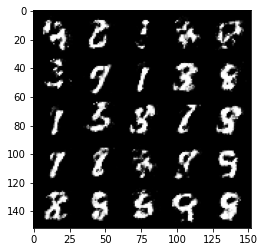

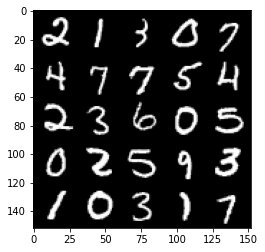

100%|██████████| 468/468 [00:09<00:00, 51.25it/s]


Step 170: Generator loss: 13.807631682157483, discriminator loss: 4.024285189568999


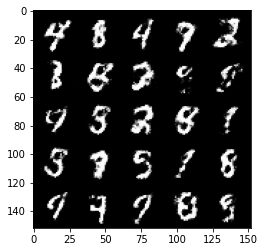

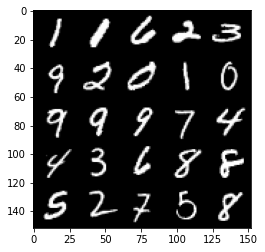

100%|██████████| 468/468 [00:09<00:00, 51.94it/s]


Step 180: Generator loss: 13.279161267042126, discriminator loss: 4.149460164248953


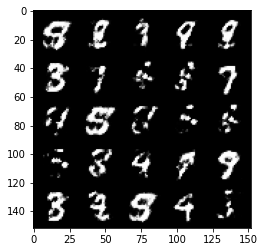

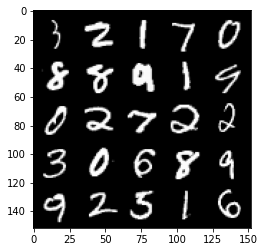

100%|██████████| 468/468 [00:09<00:00, 51.45it/s]


Step 190: Generator loss: 12.498145680427575, discriminator loss: 4.341004923701285


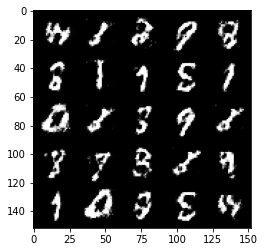

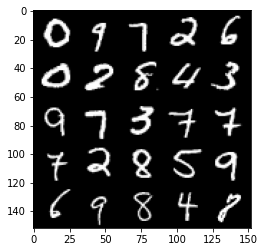

100%|██████████| 468/468 [00:08<00:00, 52.27it/s]


In [24]:
# UNQ_C8 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: 

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):    
        # Flatten the batch of real images from the dataset
        real = real.view(batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero out the gradients before backpropagation
        D_opt.zero_grad()

        # Calculate discriminator loss
        disc_loss = get_disc_loss(G, D, criterion, real, batch_size, z_dim, device)

        # Update gradients
        disc_loss.backward(retain_graph=True)

        # Update optimizer
        D_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = G.gen[0][0].weight.detach().clone()

        ### Update generator ###
        #     Hint: This code will look a lot like the discriminator updates!
        #     These are the steps you will need to complete:
        #       1) Zero out the gradients.
        #       2) Calculate the generator loss, assigning it to gen_loss.
        #       3) Backprop through the generator: update the gradients and optimizer.
        #### START CODE HERE ####
        G_opt.zero_grad()
        gen_loss = get_gen_loss(G, D, criterion, batch_size, z_dim, device)
        gen_loss.backward()
        G_opt.step()
        #### END CODE HERE ####

        # For testing purposes, to check that your code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (G.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(G.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
    if cur_step % 10 == 0 and cur_step > 0:
        print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
        fake_noise = torch.randn(batch_size, z_dim, device=device)
        fake = G(fake_noise)
        show_tensor_images(fake)
        show_tensor_images(real)
        mean_generator_loss = 0
        mean_discriminator_loss = 0
    cur_step += 1
